In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input/'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

import os

# !pip install fire
# !pip install tqdm

home_dir = '/content/gdrive/My Drive/A0/aispace'
os.chdir(home_dir)
!pwd

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/gdrive/My Drive/A0/aispace


In [3]:
!pip install rasterio
!pip install accelerate
!pip install peft
!pip install transformers
!pip install datasets

In [4]:
##### CONTROL TORCH VERSION FOR TRAINER ARTIFACTS ####################
import torch
print(torch.__version__)

2.0.1+cu118


In [5]:
import numpy as np

import great
from great import GReaT

import pandas as pd

################################
import numpy as np

import pandas as pd

# all imports should go here

import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
from rasterio.plot import show

import sklearn

import skimage.exposure

# access package for AWS access
# import boto3

import sys
import os
import subprocess
import datetime
import platform
import datetime

from tqdm import tqdm

# import ee
import h5py
import numpy as np
from datetime import datetime, timedelta  # Import timedelta here
import random
import pandas as pd

import time
import rasterio as rio
################################

# Execute only once!
import os
import sys
sys.path.append("..")
os.chdir("..")

In [6]:
os.environ['TRANSFORMERS_NO_ADVISORY_WARNINGS'] = 'true'

data = pd.read_csv('./aispace/data/L8-100x100')

display(data)

# fn

Unnamed: 0  B01  B02  B03  B04   B05   B06   B07  B09   B10  ...  \
0         3387000  328  459  815  881  2789  2594  1687   14  3175  ...   
1         3387001  329  470  840  880  2951  2433  1568   14  3184  ...   
2         3387002  263  378  725  688  2715  2197  1291   13  3193  ...   
3         3387003  245  359  704  665  2559  2245  1317   15  3198  ...   
4         3387004  279  404  764  728  2643  2302  1321   17  3196  ...   
...           ...  ...  ...  ...  ...   ...   ...   ...  ...   ...  ...   
69995     3749435  262  338  591  576  1950  2081  1194    9  2765  ...   
69996     3749436  271  350  606  577  2002  2068  1179    9  2771  ...   
69997     3749437  266  345  597  566  2000  2089  1193   14  2775  ...   
69998     3749438  268  348  596  573  2025  2122  1215   13  2773  ...   
69999     3749439  261  348  612  582  2099  2118  1194   10  2763  ...   

       snow_ice  water  aero    SAA   SZA    VAA  VZA     X     Y  DOY  
0             0      0     1  14692  3005  23006   96  1500   925  171  
1             0      0     1  14692  3005  23019   96  1501   925  171  
2             0      0     1  14692  3005  23031   96  1502   925  171  
3             0      0     1  14692  3005  23044   96  1503   925  171  
4             0      0     1  14692  3005  23057   97  1504   925  171  
...         ...    ...   ...    ...   ...    ...  ...   ...   ...  ...  
69995         0      0     2  14999  3693  24386  119  1595  1024  219  
69996         0      0     2  14999  3693  24395  119  1596  1024  219  
69997         0      0     2  14999  3693  24403  119  1597  1024  219  
69998         0      0     2  14999  3693  24411  119  1598  1024  219  
69999         0      0     2  14999  3693  24419  120  1599  1024  219  

[70000 rows x 25 columns]

In [7]:
def _image_df(input):
    BND_LIST = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B09', 'B10', 'B11']
    FMSK_LIST = ['cirrus', 'cloud', 'adj_cloud', 'cloud_shadow', 'snow_ice', 'water', 'aero' ]
    ANG_LIST = ['SAA', 'SZA', 'VAA', 'VZA',]

    box_x_size = input['X'].max() - input['X'].min() + 1
    box_y_size = input['Y'].max() - input['Y'].min() + 1

    def _get_img_nan(input, bnd_list=['B04', 'B03', 'B02']):

        print(input['DOY'].unique())

        df = input[bnd_list].copy()

        df[df > 0] = 0
        df[df == -9999] = 1
        df[df < 0] = 0

        image = df.to_numpy()  # df[chanel_list]

        image = image.transpose()
        image = image.reshape(image.shape[0], box_x_size, box_y_size)

        nans = np.dstack((image[0,:,:], image[1,:,:], image[2,:,:]))

        return nans


    def _get_img_rgb(input, bnd_list=['B04', 'B03', 'B02']):
        df = input[bnd_list].copy()

        # df[df > 0] = 0
        df[df == -9999] = np.nan
        # df[df < 0] = 0

        image = df.to_numpy()

        image = image.transpose()
        image = image.reshape(image.shape[0], box_x_size, box_y_size)

        # Convert the int16 array to int64
        # image = image.astype(np.uint64)

        r_ = (8200, 16000)
        g_ = (8500, 14000)
        b_ = (7500, 12000)


        def generalized_normalization(band, rgb):
            # Apply your normalization method here
            # Example: Stretch and scale values to 0-255
            band = np.ma.array (band, mask=np.isnan(band))

            ### FOR HLS #################
            band = 0.0001 * band
            band = np.where(band > 0.3, 0.3, band)
            min_val = -0.063
            max_val = 0.3

            # min_val = np.min(band)
            # max_val = np.max(band)
            # min_val = rgb[0]
            # max_val = rgb[1]
            # print(f'gn:{min_val}, {max_val}')
            normalized_band = ((band - min_val) / (max_val - min_val) * 255).astype(np.uint8)
            #
            # Replace elements greater than 2000 with 1
            # print('band:', band.min(), band.max())
            normalized_band[normalized_band == np.nan] = 255
            return normalized_band

        # Scale the bands to 8-bit
        scaled_red = generalized_normalization(image[2,:,:], r_)
        scaled_green = generalized_normalization(image[1,:,:], g_)
        scaled_blue = generalized_normalization(image[0,:,:], b_)

        rgb = np.dstack((scaled_red, scaled_green, scaled_blue))

        return rgb

    def _get_img(input, bnd_list):
        image = input[bnd_list].to_numpy()  # df[chanel_list]

        image = image.transpose()
        image = image.reshape(image.shape[0], box_x_size, box_y_size)

        # Convert the int16 array to int64
        image = image.astype(np.uint64)

        return image[0,:,:]

    image_nan = _get_img_nan(input, bnd_list=['B02', 'B03', 'B04'])
    image_rgb = _get_img_rgb(input, bnd_list=['B02', 'B03', 'B04'])
    image_cirrus = _get_img(input, bnd_list=['cirrus'])
    image_cloud = _get_img(input, bnd_list=['cloud'])
    image_adjcloud = _get_img(input, bnd_list=['adj_cloud'])
    image_cloud_shadow = _get_img(input, bnd_list=['cloud_shadow'])
    image_snow_ice = _get_img(input, bnd_list=['snow_ice'])
    image_water = _get_img(input, bnd_list=['water'])

    # image_rgb_list = [image_rgb, image_cirrus,] # image_cloud, image_adjcloud, image_cloud_shadow, image_snow_ice, image_water]

    # image_nan_list = [image_nan[:,:,0], image_nan[:,:,1], image_nan[:,:,2]]
    # # Create subplots
    # fig, axes = plt.subplots(1, len(image_nan_list), figsize=(18, 22))
    # # Flatten the axes array to simplify indexing
    # axes = axes.ravel()
    # # print(image_nan_list[0].shape)
    # for ii in range(0,len(image_nan_list)):
    #     axes[ii].imshow(image_nan_list[ii], cmap='gray')  # You can specify a colormap
    # plt.tight_layout()
    # plt.show()

    # # Create subplots
    # fig, axes = plt.subplots(1, len(image_rgb_list), figsize=(18, 22))
    # # Flatten the axes array to simplify indexing
    # axes = axes.ravel()
    # # print(image_rgb_list[0].shape)
    # axes[0].imshow(image_rgb_list[0])
    # # Loop through the images and plot them
    # for ii in range(1,len(image_rgb_list)):
    #     axes[ii].imshow(image_rgb_list[ii], cmap='gray')  # You can specify a colormap
    # plt.tight_layout()
    # plt.show()

    image_rgb_list = [image_rgb, image_cirrus, image_cloud, image_adjcloud, image_cloud_shadow, image_snow_ice, image_water]

    # Create subplots
    fig, axes = plt.subplots(1, len(image_rgb_list), figsize=(18, 22))
    # Flatten the axes array to simplify indexing
    axes = axes.ravel()
    # print(image_rgb_list[0].shape)
    axes[0].imshow(image_rgb_list[0])
    # Loop through the images and plot them
    for ii in range(1,len(image_rgb_list)):
        axes[ii].imshow(image_rgb_list[ii], cmap='gray')  # You can specify a colormap
    plt.tight_layout()
    plt.show()


# _image_df(data)

[203]


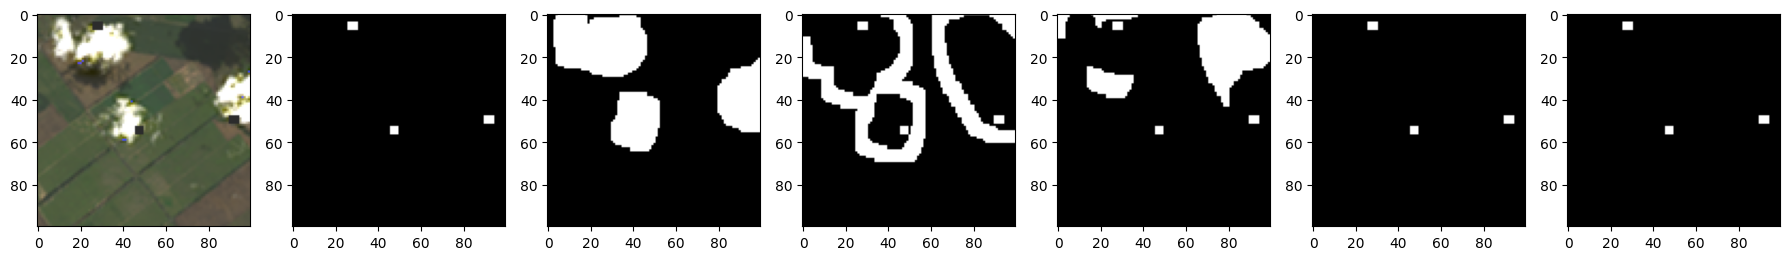

[211]


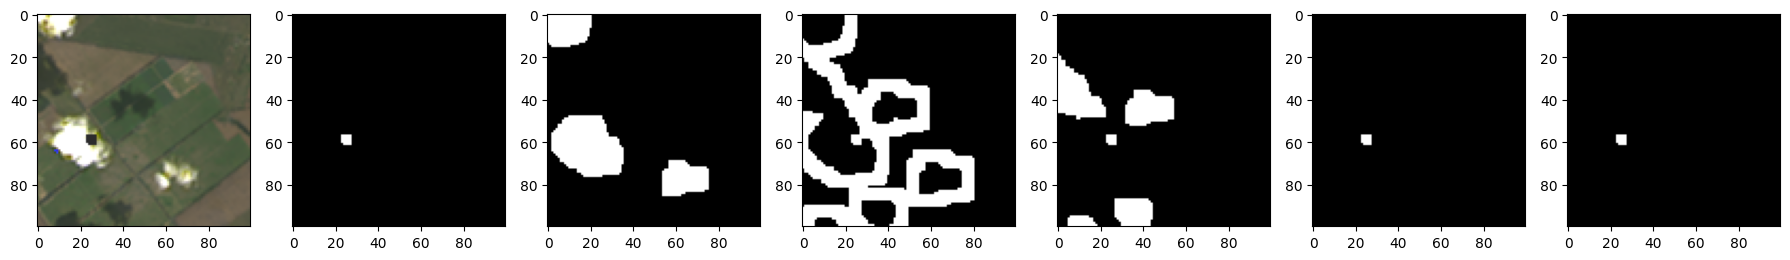

[219]


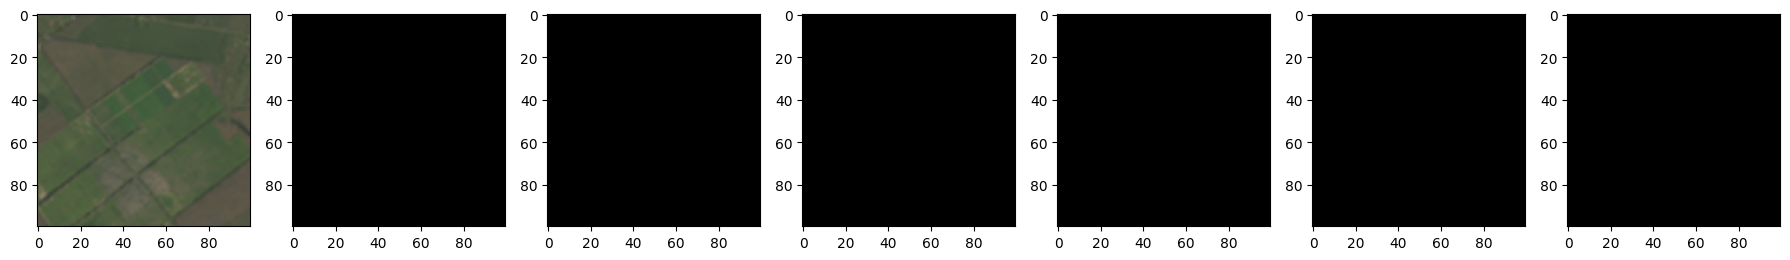

In [8]:
train_data = data
train_doys = [171, 179, 187, 195, 203, 211, 219]
train_doys = [203, 211, 219]
# train_doys = [219]
# train_data_list = []
otput_data_list = []
for doy in train_doys:
    # data = _get_hls(doy)
    # croped_data = _crop_data(data, doy)
    tr_df = train_data[ train_data['DOY'] == int(doy)].copy()
    otput_data_list.append(tr_df)
    _image_df(tr_df)
    # train_data_list.append(croped_data)
# fn
output_data = pd.concat(otput_data_list, axis=0)
train_data = output_data.copy()

In [9]:
final_columns_list = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B09', 'B10', 'B11', \
                      'cirrus', 'cloud', 'adj_cloud', 'cloud_shadow', 'snow_ice', 'water', 'aero', \
                      # 'SAA', 'SZA', 'VAA', 'VZA', \
                      'X', 'Y', 'DOY']

final_columns_list = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', \
                      'cloud', 'adj_cloud', 'cloud_shadow', 'aero', \
                      'SAA', 'SZA', 'VAA', 'VZA', \
                      'X', 'Y', 'DOY']

final_columns_list = ['B01', 'B02', 'B03', 'B04', 'B05', \
                      'cloud', 'adj_cloud', 'cloud_shadow', 'aero', \
                      # 'SAA', 'SZA', 'VAA', 'VZA', \
                      'X', 'Y', 'DOY']

final_columns_list = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B09', 'cloud', 'adj_cloud', 'cloud_shadow', 'X', 'Y', 'DOY']
final_columns_list = ['B02', 'B03', 'B04', 'cloud', 'adj_cloud', 'cloud_shadow', 'X', 'Y', 'DOY']

train_data = train_data[final_columns_list]
# train_data.columns = final_columns_list

print(train_data.columns.to_list())
display(train_data)
# fn

['B02', 'B03', 'B04', 'cloud', 'adj_cloud', 'cloud_shadow', 'X', 'Y', 'DOY']


B02  B03  B04  cloud  adj_cloud  cloud_shadow     X     Y  DOY
40000  435  792  808      0          0             1  1500   925  203
40001  492  842  911      0          0             1  1501   925  203
40002  374  660  673      0          0             1  1502   925  203
40003  289  562  550      0          0             1  1503   925  203
40004  309  566  579      0          0             1  1504   925  203
...    ...  ...  ...    ...        ...           ...   ...   ...  ...
69995  338  591  576      0          0             0  1595  1024  219
69996  350  606  577      0          0             0  1596  1024  219
69997  345  597  566      0          0             0  1597  1024  219
69998  348  596  573      0          0             0  1598  1024  219
69999  348  612  582      0          0             0  1599  1024  219

[30000 rows x 9 columns]

In [10]:
#### THIS CELL FOR DEV #############################################
def _get_balanced(input_data, n_train=4, n_test=10):

    def _balanced_sample(indata, N):
        # Specify the desired sample size N
        # N = 4
        data = indata.copy()

        # Calculate the number of 0s and 1s in the DataFrame
        num_zeros = (data[f'Clear'] == '0').sum()
        num_ones  = (data[f'Clear'] == '1').sum()

        # Ensure that N is less than or equal to the minimum of num_zeros and num_ones
        N = min(N, num_zeros, num_ones)

        # Randomly select N/2 samples of 0s and N/2 samples of 1s
        random_zeros = data[data[f'Clear'] == '0'].sample(n=N//2)
        random_ones  = data[data[f'Clear'] == '1'].sample(n=N//2)

        # Concatenate the randomly selected samples to get the final random sample
        balanced_sample = pd.concat([random_zeros, random_ones])
        return balanced_sample

    # Get N random rows from the DataFrame
    data     = _balanced_sample(input_data, n_train)
    # Shuffle the final random sample
    # data = data.sample(frac=1, random_state=42)
    # data = data[columns].loc[0:2].copy()

    val_data = _balanced_sample(input_data, n_test)
    # Shuffle the final random sample
    # val_data = val_data.sample(frac=1, random_state=42)

    return data, val_data

# train_data, test_data = _get_balanced(data, n_train=60, n_test=10)

# final_columns_list = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B09', 'B10', 'B11', \
#                       'cirrus', 'cloud', 'adj_cloud', 'cloud_shadow', 'snow_ice', 'water', 'aero', \
#                       # 'SAA', 'SZA', 'VAA', 'VZA', \
#                       'X', 'Y', 'DOY']

# Replace -9999 with np.nan
train_data.replace(-9999, np.nan, inplace=True)

# Remove rows containing np.nan in any column
# train_cleaned = train_data.dropna(how='any')

def _get_ts_pixel(data, doy, clear = 0,):
    # train_data = data.copy()

    # Randomly select N/2 samples of 0s and N/2 samples of 1s
    random_zeros = data.loc[(data[f'cloud'] == clear) & (data[f'adj_cloud'] == clear) & (data[f'cloud_shadow'] == clear) \
                          & (data[f'DOY'] == int(doy))].sample(1)


    print('_get_ts_pixel:', random_zeros.X.values[0], random_zeros.Y.values[0])

    ts_random_zeros = data.loc[(data[f'X'] == random_zeros.X.values[0]) &
                               (data[f'Y'] == random_zeros.Y.values[0])]

    balanced_sample = ts_random_zeros

    return balanced_sample

def _get_xy_pixel(data, X, Y,):

    ts_random_zeros = data.loc[(data[f'X'] == int(X)) &
                               (data[f'Y'] == int(Y))]

    print('_get_xy_pixel:', ts_random_zeros.X.values[0], ts_random_zeros.Y.values[0])

    balanced_sample = ts_random_zeros

    return balanced_sample

# balanced_sample = pd.DataFrame()
# for ii in range(2):
#     balanced_sample = pd.concat([balanced_sample, _get_ts_pixel(train_cleaned, doy = 219, clear = 0)], axis=0)

# # for ii in range(2):
# #     balanced_sample = pd.concat([balanced_sample, _get_ts_pixel(train_cleaned, doy = 203, clear = 1)], axis=0)


# # balanced_sample = pd.DataFrame()
# # for ii in range(2):
# #     balanced_sample = pd.concat([balanced_sample, _get_xy_pixel(train_cleaned, X = 1550, Y = 1000)], axis=0)

# # for ii in range(2):
# #     balanced_sample = pd.concat([balanced_sample, _get_xy_pixel(train_cleaned, X = 1550, Y = 1000)], axis=0)
# #   # balanced_sample = pd.concat([balanced_sample, _get_ts_pixel(_data, clear = 1)], axis=0)



# # fn

# # Get the list of row indices
# selected_indices = balanced_sample.index.tolist()

# print(selected_indices)

# # fn

# # selected_indices = [5913, 15913, 25913, 35913, 45913, 55913, 65913,
# #                     5304, 15304, 25304, 35304, 45304, 55304, \
# #                         65304, 4380, 14380, 24380, 34380, 44380, 54380, 64380, 137, 10137, 20137, 30137, 40137, 50137, 60137]

# # selected_indices = [44261, 54261, 64261, 48363, 58363, 68363, 40137, 50137, 60137, 42935, 52935, 62935]

# print('interchange:', selected_indices)

# # Create a new DataFrame with the selected indices
# balanced_sample = train_cleaned.loc[selected_indices]

# final_columns_token_list = ['A', 'B', 'C', 'D', 'E', \
#                             'F', 'G', 'H', 'I', \
#                           # 'SAA', 'SZA', 'VAA', 'VZA', \
#                             'G', 'K', 'L']

# # Replace the column names
# balanced_sample.columns = final_columns_token_list
# display(balanced_sample)
#### FOR CLEARED DATASET ########################
balanced_sample = train_data.copy()

# ###### GET CLEAR PIXELS ONLY ###########################
# def _get_clear(data):
#     cleared_data = data.loc[(data[f'cloud'] == 0) & (data[f'adj_cloud'] == 0) & (data[f'cloud_shadow'] == 0)].copy()
#     return cleared_data

# train_cleared = _get_clear(balanced_sample)
# balanced_sample = train_cleared.copy()
# ########################################################
###### GET CLEAR PIXELS ONLY ###########################
def _get_nan(data):
    nan_data = data.copy()
    nan_data.loc[(nan_data[f'cloud'] == 1) | (nan_data[f'adj_cloud'] == 1) | (nan_data[f'cloud_shadow'] == 1), ['B02', 'B03', 'B04']] = np.NaN
    return nan_data

test_nan = _get_nan(balanced_sample)
balanced_sample = test_nan.copy()
########################################################
# Delete the specified columns
balanced_sample = balanced_sample.drop(columns=['cloud', 'adj_cloud', 'cloud_shadow'], axis=1)

# Reset the index to remove it
balanced_sample = balanced_sample.reset_index(drop=True)

final_columns_list = ['B02', 'B03', 'B04', 'X', 'Y', 'DOY']
balanced_sample.columns = final_columns_list

display(balanced_sample)

test_data = balanced_sample.copy()
# fn

B02    B03    B04     X     Y  DOY
0        NaN    NaN    NaN  1500   925  203
1        NaN    NaN    NaN  1501   925  203
2        NaN    NaN    NaN  1502   925  203
3        NaN    NaN    NaN  1503   925  203
4        NaN    NaN    NaN  1504   925  203
...      ...    ...    ...   ...   ...  ...
29995  338.0  591.0  576.0  1595  1024  219
29996  350.0  606.0  577.0  1596  1024  219
29997  345.0  597.0  566.0  1597  1024  219
29998  348.0  596.0  573.0  1598  1024  219
29999  348.0  612.0  582.0  1599  1024  219

[30000 rows x 6 columns]

In [11]:
def _image_df(input):
    BND_LIST = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B09', 'B10', 'B11']
    FMSK_LIST = ['cirrus', 'cloud', 'adj_cloud', 'cloud_shadow', 'snow_ice', 'water', 'aero' ]
    ANG_LIST = ['SAA', 'SZA', 'VAA', 'VZA',]

    box_x_size = input['X'].max() - input['X'].min() + 1
    box_y_size = input['Y'].max() - input['Y'].min() + 1

    def _get_img_nan(input, bnd_list=['B04', 'B03', 'B02']):

        print(input['DOY'].unique())

        df = input[bnd_list].copy()

        df[df > 0] = 0
        df[df == -9999] = 1
        df[df < 0] = 0

        image = df.to_numpy()  # df[chanel_list]

        image = image.transpose()
        image = image.reshape(image.shape[0], box_x_size, box_y_size)

        nans = np.dstack((image[0,:,:], image[1,:,:], image[2,:,:]))

        return nans


    def _get_img_rgb(input, bnd_list=['B04', 'B03', 'B02']):
        df = input[bnd_list].copy()

        # df[df > 0] = 0
        df[df == -9999] = np.nan
        # df[df < 0] = 0

        image = df.to_numpy()

        image = image.transpose()
        image = image.reshape(image.shape[0], box_x_size, box_y_size)

        # Convert the int16 array to int64
        # image = image.astype(np.uint64)

        r_ = (8200, 16000)
        g_ = (8500, 14000)
        b_ = (7500, 12000)


        def generalized_normalization(band, rgb):
            # Apply your normalization method here
            # Example: Stretch and scale values to 0-255
            band = np.ma.array (band, mask=np.isnan(band))

            ### FOR HLS #################
            band = 0.0001 * band
            band = np.where(band > 0.3, 0.3, band)
            min_val = -0.063
            max_val = 0.3

            # min_val = np.min(band)
            # max_val = np.max(band)
            # min_val = rgb[0]
            # max_val = rgb[1]
            # print(f'gn:{min_val}, {max_val}')
            normalized_band = ((band - min_val) / (max_val - min_val) * 255).astype(np.uint8)
            #
            # Replace elements greater than 2000 with 1
            # print('band:', band.min(), band.max())
            normalized_band[normalized_band == np.nan] = 255
            return normalized_band

        # Scale the bands to 8-bit
        scaled_red = generalized_normalization(image[2,:,:], r_)
        scaled_green = generalized_normalization(image[1,:,:], g_)
        scaled_blue = generalized_normalization(image[0,:,:], b_)

        rgb = np.dstack((scaled_red, scaled_green, scaled_blue))

        return rgb

    def _get_img(input, bnd_list):
        image = input[bnd_list].to_numpy()  # df[chanel_list]

        image = image.transpose()
        image = image.reshape(image.shape[0], box_x_size, box_y_size)

        # Convert the int16 array to int64
        image = image.astype(np.uint64)

        return image[0,:,:]

    # image_nan = _get_img_nan(input, bnd_list=['B02', 'B03', 'B04'])
    image_rgb = _get_img_rgb(input, bnd_list=['B02', 'B03', 'B04'])

    image_rgb_list = [image_rgb, image_rgb]

    # Create subplots
    fig, axes = plt.subplots(1, len(image_rgb_list), figsize=(18, 22))
    # Flatten the axes array to simplify indexing
    axes = axes.ravel()
    # print(image_rgb_list[0].shape)
    axes[0].imshow(image_rgb_list[0])
    # Loop through the images and plot them
    for ii in range(1,len(image_rgb_list)):
        axes[ii].imshow(image_rgb_list[ii], cmap='gray')  # You can specify a colormap
    plt.tight_layout()
    plt.show()

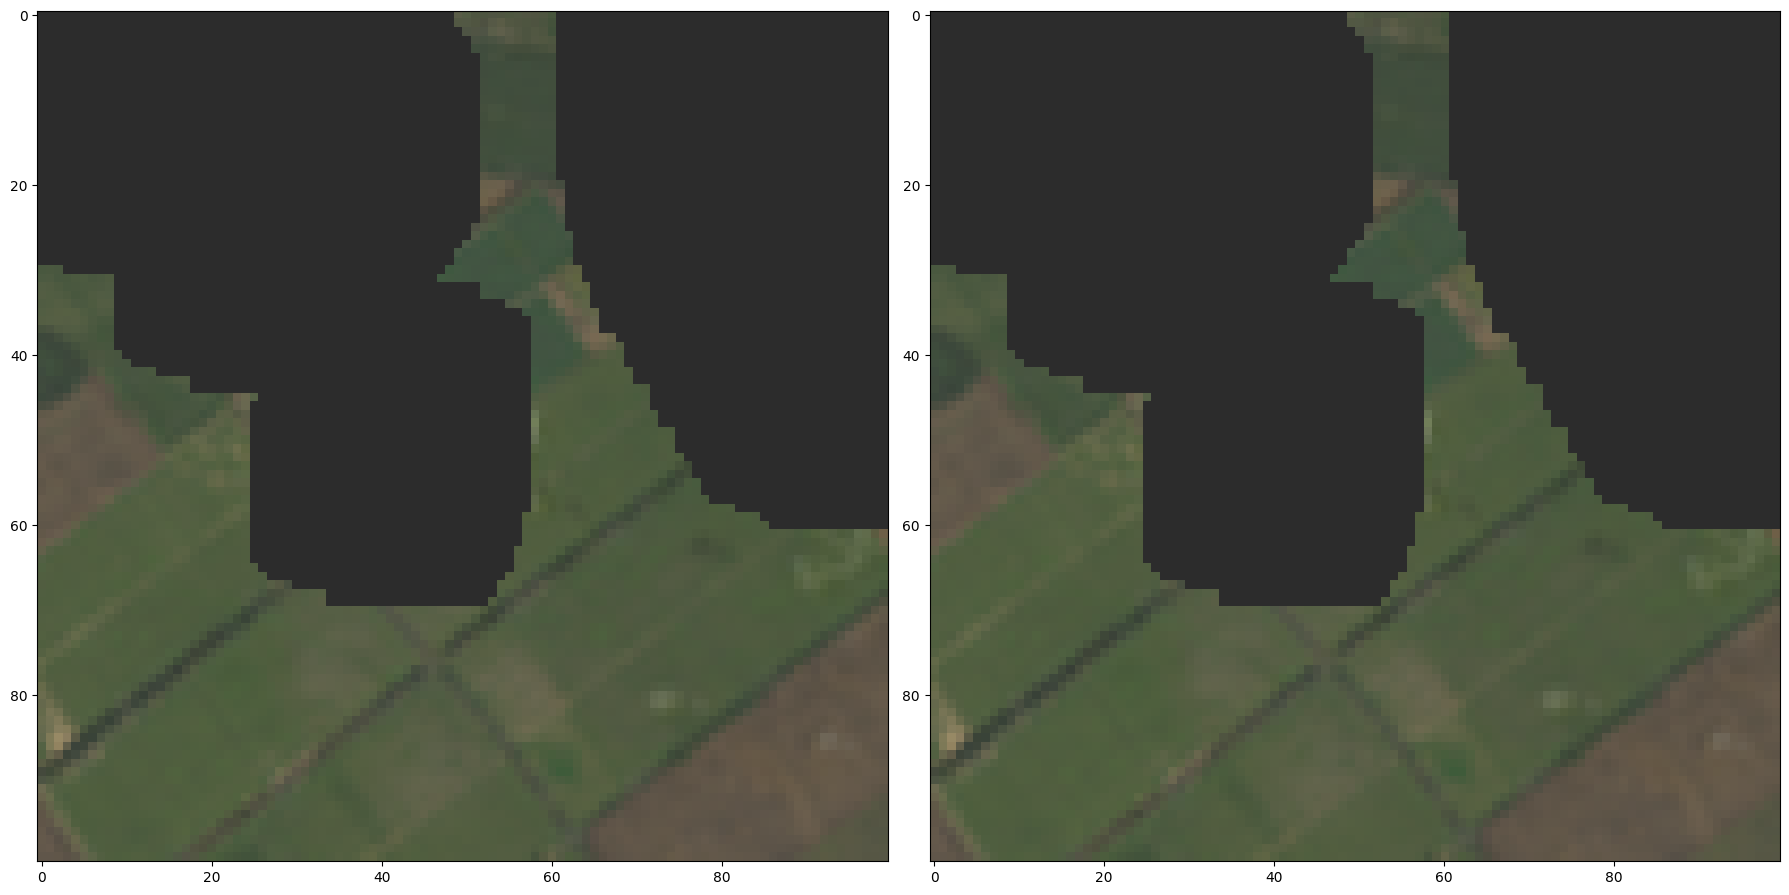

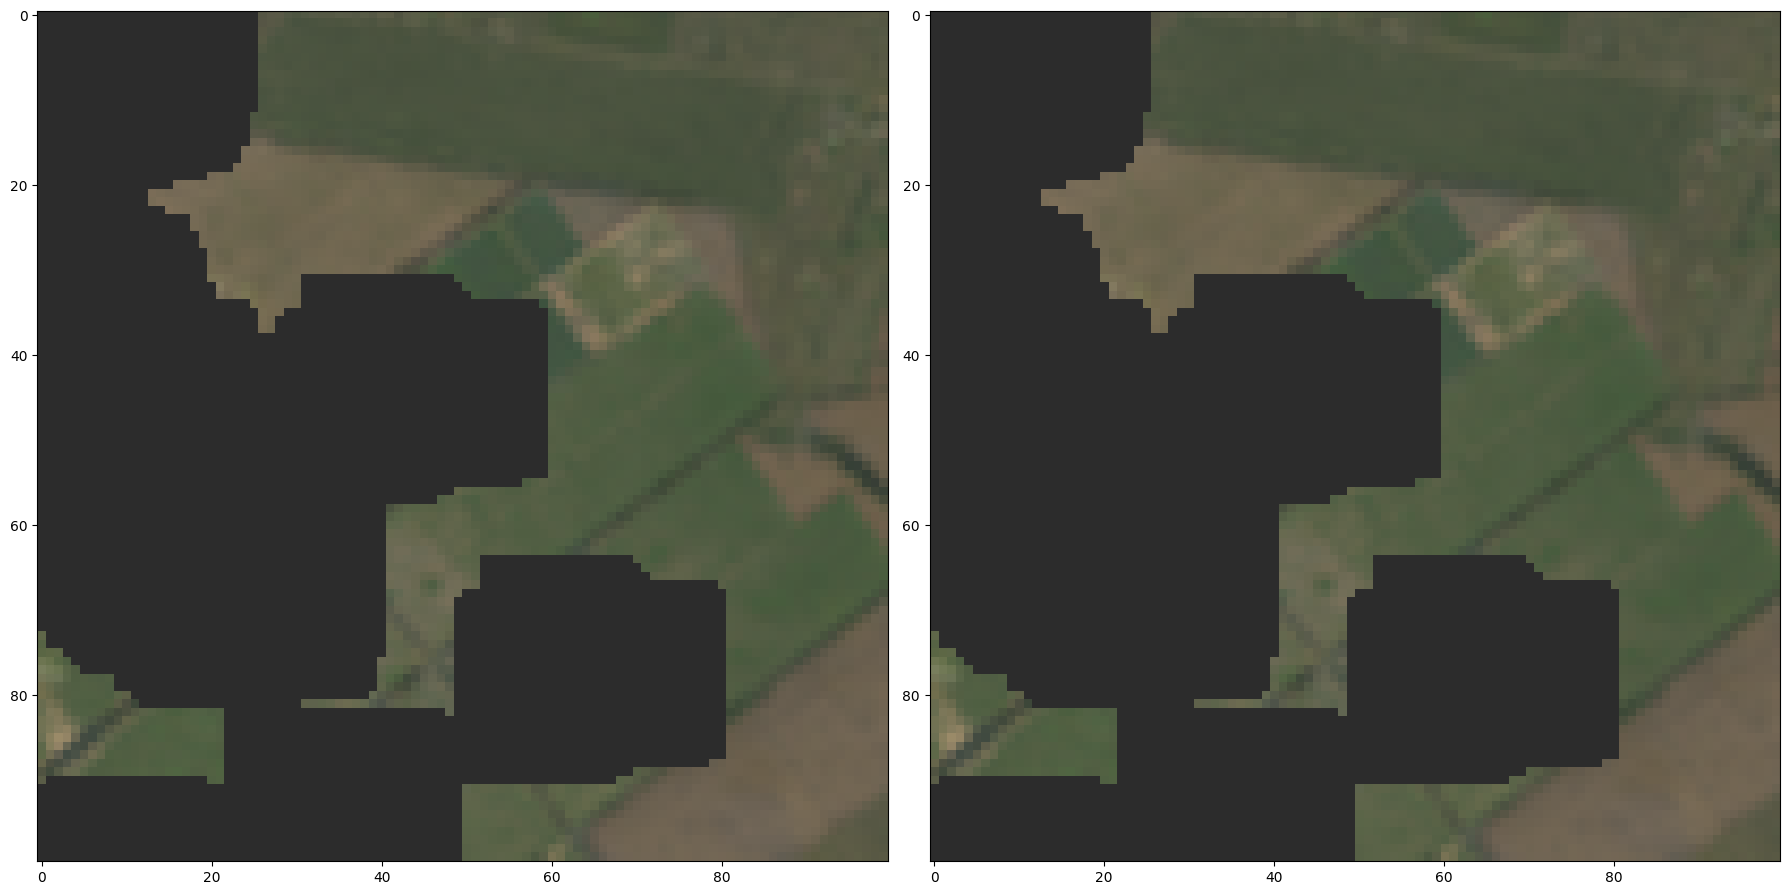

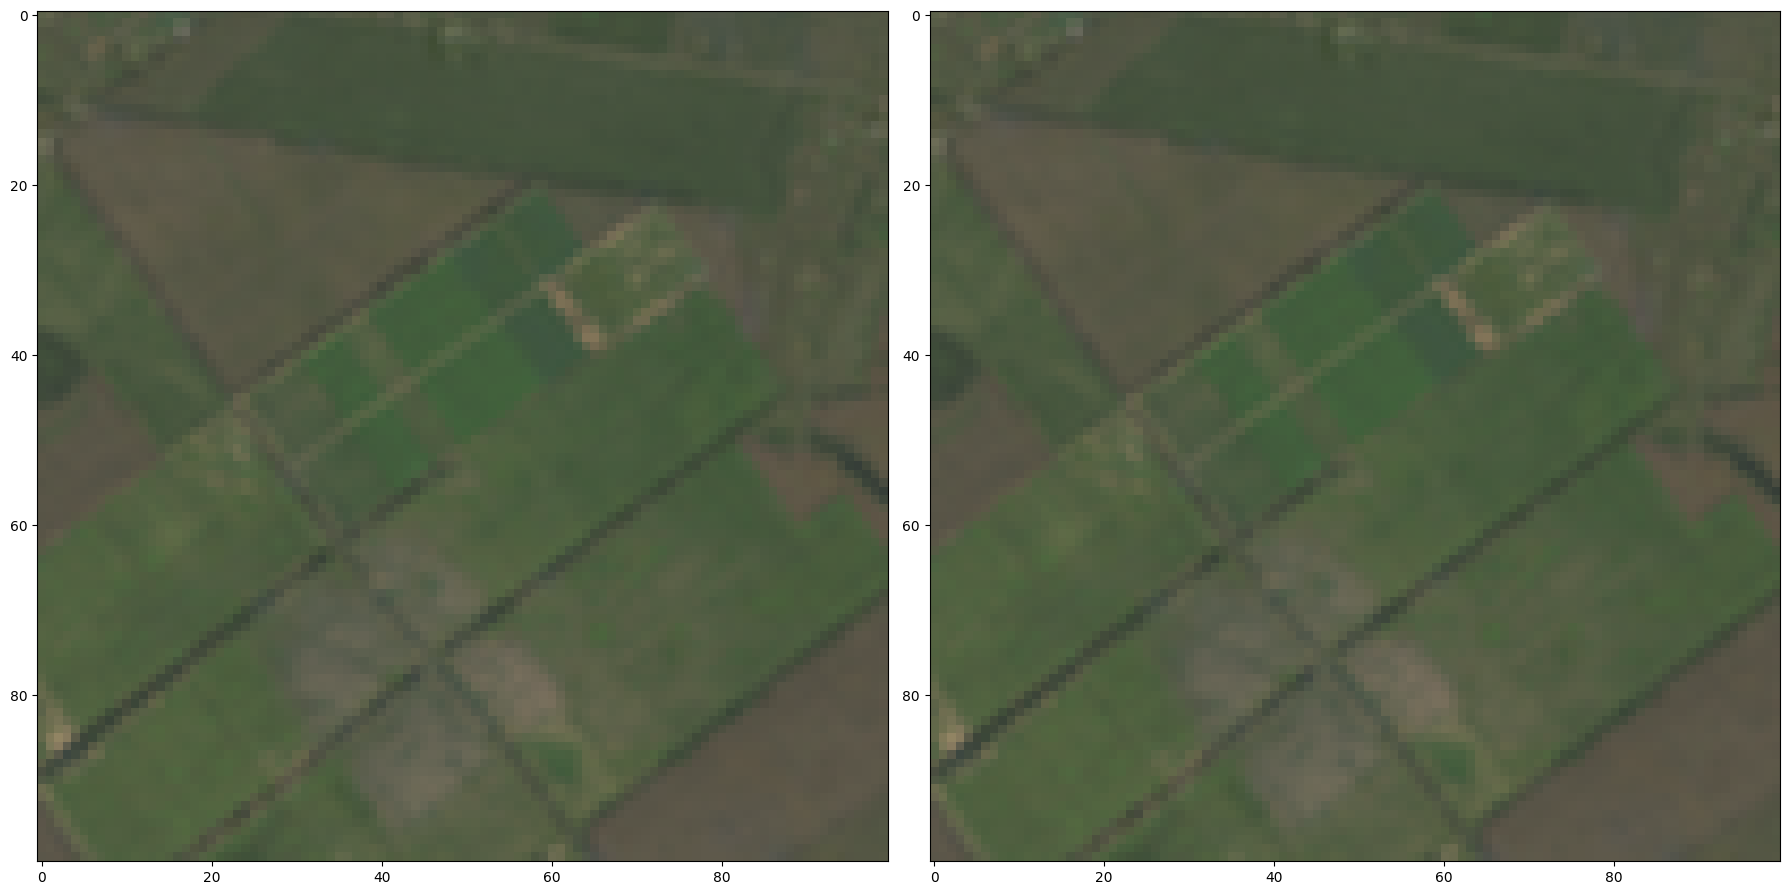

In [12]:
# train_data = data
doys = [171, 179, 187, 195, 203, 211, 219]
doys = [203, 211, 219]
# train_doys = [219]
# train_data_list = []
otput_data_list = []
for doy in doys:
    # data = _get_hls(doy)
    # croped_data = _crop_data(data, doy)
    tr_df = test_data[ test_data['DOY'] == int(doy)].copy()
    # otput_data_list.append(tr_df)
    _image_df(tr_df)
    # train_data_list.append(croped_data)
# fn
# output_data = pd.concat(otput_data_list, axis=0)
# train_data = output_data.copy()
# fn

In [15]:
# model_load_dir = f'./{EXP_NAME}' #+'_FST0'
# model_save_dir = f'./{EXP_NAME}'

train_data = test_data.copy()

# train_data = balanced_sample.copy() #[0:1000]

# # display(train_data)

table_dtype = 'int16'

# train_data = train_data.astype(table_dtype)
# print(train_data.dtypes.tolist())

# # Reset the index to remove it
# train_data = train_data.reset_index(drop=True)

# train_data.columns = final_columns_list

# display(train_data)
# fn

# # train_data = train_data_.sample(frac=1.0) #.reset_index(inplace=True)
# # Generate a random state based on CPU time
# current_time = int(time.time())
# random_state = current_time % (2**32)  # Use the current time as the seed (limit to 32 bits)
# # Shuffle the DataFrame using the generated random state
# train_data_shuffled = sklearn.utils.shuffle(train_data_, random_state=random_state)
# train_data = train_data_shuffled.copy()

# #### FOR CPU USABILITY, for 2 pixels #################################
# epochs_steps = 1  # 250 #50
# save_steps = 1   #250 #50 #9380  #2000   # FOR FIT THIS VALUE START TRAIN DATASET, EQUALS FOR STEPS IN FIRST START
# logging_steps = 1 # 250 #25 #9380  #1000

#### FOR GPU USABILITY################################
epochs_steps = 26010 # 400   # 250 #50
save_steps = 1000   #250 #50 #9380  #2000   # FOR FIT THIS VALUE START TRAIN DATASET, EQUALS FOR STEPS IN FIRST START
logging_steps = 200 # 250 #25 #9380  #1000
#### batch_size = 250 for T4
batch_size = 312 #250 #312  # 224 # 250 #300 #164 for float64 # 112 # for float64 # 136 # 96   # 140# 400
#######################################

# #### FOR GPU USABILITY################################
# epochs_steps = 800   # 250 #50
# save_steps = 10000   #250 #50 #9380  #2000   # FOR FIT THIS VALUE START TRAIN DATASET, EQUALS FOR STEPS IN FIRST START
# logging_steps = 500 # 250 #25 #9380  #1000
# #### batch_size = 250 for T4
# batch_size = 800 #250 #312  # 224 # 250 #300 #164 for float64 # 112 # for float64 # 136 # 96   # 140# 400
# #######################################


# ALL_EPOCHS = 150000
# checkpoint_id = f'{1}'

EXP_NAME = 'exp-A100'
EXP_NAME = 'exp0'

#### 1 ###########
# learning_rate = 5e-5
# lr_scheduler_type = 'constant' # constant_with_warmup

learning_rate = 0.001
lr_scheduler_type = 'cosine_with_restarts'
lr_scheduler_type = 'constant_with_warmup'

# experiment_dir = "trainer_RGB_float64"

# calc_device = 'V-100'

experiment_dir = f'{EXP_NAME}/trainer_RGB_{table_dtype}_lr{learning_rate}'  #_{lr_scheduler_type}'

efficient_finetuning = ''  #'lora'
if efficient_finetuning == 'lora':
    experiment_dir = f"{EXP_NAME}/{experiment_dir}_{efficient_finetuning}"

model_save_dir = f'{EXP_NAME}/ZeroModel_{efficient_finetuning}'

# experiment_dir = './input/chkpoint/' + experiment_dir
# print('experiment_dir:', experiment_dir)

FIRST_START = 0


model = GReaT(llm=f'{experiment_dir}/checkpoint-26000',
              batch_size=batch_size, epochs=epochs_steps+10, logging_steps=logging_steps, save_steps=save_steps,
              # dataloader_num_workers=2, #fp16=True,
              save_total_limit=2,
              prediction_loss_only=True,
              experiment_dir=experiment_dir,
              dataloader_num_workers=2,
              efficient_finetuning = efficient_finetuning,
              learning_rate=learning_rate,
              lr_scheduler_type=lr_scheduler_type,
              warmup_ratio=0.25,
              # optim='adamw_torch_fused',
              fp16 = True,
              # torch_compile=True,
              # bf16=True,
              # warmup_steps=1500,
              # lr_scheduler_type='cosine_with_restarts',
              #torch_compile=True, bf16=True,  #optim='adamw_torch_fused',#auto_find_batch_size=True,
              # use_cpu=True, # fp16 = True, #fp16_opt_level='O3', #half_precision_backend='auto',
              )

print(model.model)
# fn

# model.fit(train_data)

display(test_data[29995:29996])
# fn

model.fit(test_data[29995:29996], resume_from_checkpoint=f'{experiment_dir}/checkpoint-26000')

fn

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


B02    B03    B04     X     Y  DOY
29995  338.0  591.0  576.0  1595  1024  219

RuntimeError: ignored

In [ ]:
# learning_rate = 0.001
# lr_scheduler_type = 'cosine_with_restarts'

# experiment_dir = "trainer_RGB_float64"

# experiment_dir = f"trainer_RGB_float64_lr{learning_rate}"

# efficient_finetuning = 'lora'
# if efficient_finetuning == 'lora':
#     experiment_dir = f"{experiment_dir}_{efficient_finetuning}_{lr_scheduler_type}"

# !pwd

# f'{experiment_dir}/checkpoint-25000'

# #### FOR CPU USABILITY, for 2 pixels #################################
# epochs_steps = 200   # 250 #50
# save_steps = 1000   #250 #50 #9380  #2000   # FOR FIT THIS VALUE START TRAIN DATASET, EQUALS FOR STEPS IN FIRST START
# logging_steps = 50 # 250 #25 #9380  #1000

# # batch_size = 224  # for full ts and full chanell list
# batch_size = 164 # 112 # for float64 # 136 # 96   # 140# 400
# #######################################

# # experiment_dir = './checkpoint-25000'
# # model = GReaT(llm=experiment_dir,
# #               # batch_size=batch_size, epochs=epochs_steps, logging_steps=logging_steps, save_steps=save_steps,
# #               # dataloader_num_workers=2, #fp16=True,
# #               # save_total_limit=2,
# #               # prediction_loss_only=True,
# #               experiment_dir=experiment_dir,
# #               # efficient_finetuning = efficient_finetuning,
# #               # learning_rate=learning_rate,
# #               # lr_scheduler_type=lr_scheduler_type,
# #               # warmup_steps=1500,
# #               # lr_scheduler_type='cosine_with_restarts',
# #               #torch_compile=True, bf16=True,  #optim='adamw_torch_fused',#auto_find_batch_size=True,
# #               # use_cpu=True, # fp16 = True, #fp16_opt_level='O3', #half_precision_backend='auto',
# #               )

# model = GReaT(llm='distilgpt2',   #llm=f'{experiment_dir}/checkpoint-25000',
#               batch_size=batch_size, epochs=epochs_steps+1, logging_steps=logging_steps, save_steps=save_steps,
#               # dataloader_num_workers=2, #fp16=True,
#               save_total_limit=2,
#               prediction_loss_only=True,
#               experiment_dir=experiment_dir,
#               efficient_finetuning = efficient_finetuning,
#               learning_rate=learning_rate,
#               lr_scheduler_type=lr_scheduler_type,
#               # lr_scheduler_type='cosine_with_restarts',
#               #torch_compile=True, bf16=True,  #optim='adamw_torch_fused',#auto_find_batch_size=True,
#               # use_cpu=True, # fp16 = True, #fp16_opt_level='O3', #half_precision_backend='auto',
#               )

# # model = GReaT.load_from_dir(experiment_dir)

# # print(model.model)

# display(test_data[29995:29996])
# # fn

# model.fit(test_data[29995:29996], resume_from_checkpoint=f'{experiment_dir}/checkpoint-25000')

In [ ]:
nan_data = test_data[test_data.isnull().any(axis=1)].astype('float64').copy()
# Reset the index to remove it
nan_data = nan_data.reset_index(drop=True)
print(nan_data.dtypes.tolist())

display(nan_data)

print(f'NumPy version:{np.__version__}')
np.float = float

imputed_data = model.impute(nan_data, k=256, max_length=50000, temperature=0.01) #, device='cpu')

display(test_data)
display(imputed_data)

imputed_data.to_csv('imputed_output.csv')

In [ ]:
fn

In [ ]:
EXP_NAME = 'exp0'

model_load_dir = f'./{EXP_NAME}' #+'_FST0'
model_save_dir = f'./{EXP_NAME}'

train_data = balanced_sample.copy() #[0:1000]

# display(train_data)

train_data = train_data.astype('float64')
print(train_data.dtypes.tolist())

# Reset the index to remove it
train_data = train_data.reset_index(drop=True)

train_data.columns = final_columns_list

display(train_data)
# fn

# # train_data = train_data_.sample(frac=1.0) #.reset_index(inplace=True)
# # Generate a random state based on CPU time
# current_time = int(time.time())
# random_state = current_time % (2**32)  # Use the current time as the seed (limit to 32 bits)
# # Shuffle the DataFrame using the generated random state
# train_data_shuffled = sklearn.utils.shuffle(train_data_, random_state=random_state)
# train_data = train_data_shuffled.copy()

#### FOR CPU USABILITY, for 2 pixels #################################
epochs_steps = 200   # 250 #50
save_steps = 1000   #250 #50 #9380  #2000   # FOR FIT THIS VALUE START TRAIN DATASET, EQUALS FOR STEPS IN FIRST START
logging_steps = 50 # 250 #25 #9380  #1000

# batch_size = 224  # for full ts and full chanell list
batch_size = 164 # 112 # for float64 # 136 # 96   # 140# 400
#######################################

FIRST_START = 1
ALL_EPOCHS = 150000

checkpoint_id = f'{1}'

#### 1 ###########
# learning_rate = 5e-5
# lr_scheduler_type = 'constant' # constant_with_warmup

learning_rate = 0.001
lr_scheduler_type = 'cosine_with_restarts'

experiment_dir = "trainer_RGB_float64"

experiment_dir = f"trainer_RGB_float64_lr{learning_rate}"

efficient_finetuning = 'lora'
if efficient_finetuning == 'lora':
    experiment_dir = f"{experiment_dir}_{efficient_finetuning}_{lr_scheduler_type}"


icount = 1
while (FIRST_START < 2):
    if FIRST_START == 0:
        print('First start...')
        model = GReaT(llm='distilgpt2',
                      batch_size=batch_size, epochs=epochs_steps, logging_steps=logging_steps, save_steps=save_steps,
                      # dataloader_num_workers=2, #fp16=True,
                      save_total_limit=2,
                      prediction_loss_only=True,
                      experiment_dir=experiment_dir,
                      efficient_finetuning = efficient_finetuning,
                      learning_rate=learning_rate,
                      lr_scheduler_type=lr_scheduler_type,
                      warmup_steps=1500,
                      # lr_scheduler_type='cosine_with_restarts',
                      #torch_compile=True, bf16=True,  #optim='adamw_torch_fused',#auto_find_batch_size=True,
                      # use_cpu=True, # fp16 = True, #fp16_opt_level='O3', #half_precision_backend='auto',
                      )

        # print(model.model)
        # fn

        model.fit(train_data)
        # model.save(model_save_dir+'_FST0')
        FIRST_START = 1
        icount = icount + 1
    elif FIRST_START == 1:
        print(f'Resume_from_checkpoint checkpoint-{experiment_dir}...')
        # f'./trainer_great/checkpoint-{checkpoint_id}
        model = GReaT(llm='distilgpt2',
                      batch_size=batch_size, epochs=icount*epochs_steps, logging_steps=logging_steps, save_steps=save_steps,
                      # dataloader_num_workers=2, #fp16=True,
                      save_total_limit=2,
                      prediction_loss_only=True,
                      experiment_dir=experiment_dir,
                      efficient_finetuning = efficient_finetuning,
                      learning_rate=learning_rate,
                      lr_scheduler_type=lr_scheduler_type,
                      warmup_steps=1500,
                      # lr_scheduler_type='cosine_with_restarts',
                      #torch_compile=True, bf16=True,  #optim='adamw_torch_fused',#auto_find_batch_size=True,
                      # use_cpu=True, # fp16 = True, #fp16_opt_level='O3', #half_precision_backend='auto',
                      )

        icount = icount + 1

        # model.save(model_save_dir)

        model.fit(train_data, resume_from_checkpoint=True)

        if  (icount > 300):
            FIRST_START = 2


In [ ]:
fn

In [ ]:
# EXP = 0

#### FOR T4 USABILITY ####################
# FIRST_START = 1
# epoch_step = 20
# save_steps = 400 #9380  #2000   # FOR FIT THIS VALUE START TRAIN DATASET, EQUALS FOR STEPS IN FIRST START
# logging_steps = 400 #9380  #1000
# ALL_EPOCHS = 500
# # batch_size = 224  # for full ts and full chanell list
# batch_size = 140# 400
#######################################

#### FOR CPU USABILITY, for 2 pixels #################################
epoch_step = 400   # 250 #50
save_steps = 400   #250 #50 #9380  #2000   # FOR FIT THIS VALUE START TRAIN DATASET, EQUALS FOR STEPS IN FIRST START
logging_steps = 200 # 250 #25 #9380  #1000

# batch_size = 224  # for full ts and full chanell list
batch_size = 96    # 140# 400
#######################################

#### FOR CPU USABILITY, for 2 pixels #################################
epoch_step = 10   # 250 #50
save_steps = 400   #250 #50 #9380  #2000   # FOR FIT THIS VALUE START TRAIN DATASET, EQUALS FOR STEPS IN FIRST START
logging_steps = 10 # 250 #25 #9380  #1000

# batch_size = 224  # for full ts and full chanell list
batch_size = 1   # 140# 400
#######################################


FIRST_START = 1
ALL_EPOCHS = 150000    # MUST BEEN GREATER THAN -> start_epoch_resumed = 5000 + epoch_step
start_epoch_resumed = 0  # 1000 + epoch_step #None for 1st start, and need to be adapted with the last trained epoch

# display(train_data)

train_data_ = balanced_sample.copy()

# display(train_data_)

old_learning_rate = 0.00001
old_lr_scheduler_type = 'linear'

learning_rate = 0.000001
lr_scheduler_type = 'constant'

EXP_NAME = 'exp0'

model_load_dir = f'./{EXP_NAME}' #+'_FST0'
model_save_dir = f'./{EXP_NAME}'

if FIRST_START == 0:
    model_load_dir = f'./{EXP_NAME}'+'_FST0'

# Generate a list of numbers between 0.1 and 0.001 with 10,000 points
learning_rate_start = 0.001
learning_rate_end = 0.00001
learning_rate_num_points = 10000
# Calculate the step size
learning_rate_step_size = (learning_rate_start - learning_rate_end) / (learning_rate_num_points - 1)
# Use a list comprehension to generate the list of numbers
learning_rate_points = [learning_rate_start - i * learning_rate_step_size for i in range(learning_rate_num_points)]

#### TRAIN CICLE ##############################
while FIRST_START < 2:
    if FIRST_START == 0:
        print('First start...')
        model = GReaT(llm='distilgpt2', batch_size=batch_size, epochs=epoch_step, logging_steps=logging_steps, save_steps=save_steps,
                      dataloader_num_workers=2, #fp16=True,
                      save_total_limit=2,
                      learning_rate=learning_rate,
                      lr_scheduler_type=lr_scheduler_type,
                      # lr_scheduler_type='cosine_with_restarts',
                      #torch_compile=True, bf16=True,  #optim='adamw_torch_fused',#auto_find_batch_size=True,
                      # use_cpu=True, # fp16 = True, #fp16_opt_level='O3', #half_precision_backend='auto',
                      )
        train_data = train_data_.copy().sample(frac=1.0) #.reset_index(inplace=True)
        model.fit(train_data)
        model.save(model_save_dir+'_FST0')
        FIRST_START = 1
        start_epoch_resumed = epoch_step + epoch_step
        # train_data = balanced_sample.copy().sample(frac=1.0)
    elif FIRST_START == 1:
        print(f'Resume_from_checkpoint {model_load_dir}...')
        # train_data = balanced_sample.copy().sample(frac=1.0)
        epochs_list = [ep for ep in range(start_epoch_resumed, ALL_EPOCHS + 1, epoch_step)]
        for epoch_ in epochs_list:
            print(f'Epoch {epoch_} resumed...')

            # Start the timer
            start_time = time.time()

            ############################
            model = GReaT(llm='distilgpt2', batch_size=batch_size, epochs=epoch_step, logging_steps=logging_steps, save_steps=save_steps,
                          dataloader_num_workers=2, #fp16=True,
                          learning_rate=learning_rate,
                          lr_scheduler_type=lr_scheduler_type,
                         )
            model.load_finetuned_model(f'{model_load_dir}/model.pt')
            ############################
            model_load_dir = model_save_dir

            ######## PRINT MODEL ################################
            # print(model.model)
            #####################################################

            # model = GReaT.load_from_dir(model_save_dir)

            model_time = time.time()

            # train_data = train_data_.sample(frac=1.0) #.reset_index(inplace=True)
            # Generate a random state based on CPU time
            current_time = int(time.time())
            random_state = current_time % (2**32)  # Use the current time as the seed (limit to 32 bits)
            # Shuffle the DataFrame using the generated random state
            train_data_shuffled = sklearn.utils.shuffle(train_data_, random_state=random_state)
            train_data = train_data_shuffled.copy()
            display(train_data.head(4))

            model.fit(train_data)      #, resume_from_checkpoint = True)  # './trainer_great/checkpoint-5000')

            model.save(model_save_dir)

            del model

            # End the timer
            end_time = time.time()

            # Calculate and print the elapsed time
            elapsed_time = (end_time - start_time) / 60
            model_load_time = (model_time - start_time) / 60
            model_fit_time = (end_time - model_time) / 60
            print(f"Elapsed time for epoch {epoch_}: model loading:{model_load_time}, model fit:{model_fit_time} elapsed:{elapsed_time} minutes")

        FIRST_START = 2

fn


In [ ]:
fn